# 2. EDA

Goals:

- Select the variables for predictions.
- Discover other interesting trends.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import *
from scipy import stats
import statsmodels.api as sm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

sns.set()

pd.set_option('display.max_columns', 80)

In [2]:
%%time
training = pd.read_excel("../data/training_cleaned.xlsx")
test = pd.read_excel("../data/test_cleaned.xlsx")
# Some entries in Total Received Principle miss the closest integer value by 0.0001. We round them.
training["Total Received Principle"] = training["Total Received Principle"].round()
test["Total Received Principle"] = test["Total Received Principle"].round()
# Scaling the interest rate.
training["Interest Rate"] *= 100
test["Interest Rate"] *= 100

Wall time: 25.5 s


In [3]:
def default_rate(lc_df):
    return lc_df["Loan Status"].mean()

In [4]:
training[["Interest Rate"]].describe()

,Interest Rate
count,35059.000000
mean,11.945231
std,3.682176
min,5.420000
25%,8.940000
50%,11.830000
75%,14.460000
max,24.590000


In [5]:
training.dtypes.to_frame()

,0
Loan Amount,int64
Funded Amount,int64
Funded Amount Investor,float64
Term,object
Interest Rate,float64
Installment,float64
Grade,object
Sub Grade,object
Loan Status,int64
Issued Date,datetime64[ns]


## 2.1 Variable Selection

The purpose of this section is to select variables that will be used for predictive modeling. Recall we divided original variables into 4 baskets: Loan Conditions, Borrower Financial Strength, Credit Situation, and Payment History on Loans. Through both empirical reasoning and statistical testing, we identify 4-5 most significant variables for each category. Then we further shrink that list to less than 10 variables using correlation analysis and dimension reduction techniques.

Parrallely, we'll also perform some automated, model-based feature selection. These techniques typically utilize classifiers with L1 penalties which, when properly adjusted, will render the coefficients on some features 0. The downside of this method is its lack in interpretability: we almost never know why the variables are discarded. We simply include the results here as reference.

__Framework for basket-wise EDA__

1. First, within each basket, we identify a couple of variables that seem too essential to exclude. For example, for loan conditions they would be `Loan Size` and `Interest Rate`. 

1. We then incrementally test the inclusion of other variables. 

    1. For each variable, we first visually check whether by it by itself has any impact on default. We discard the variable if no correlation can be seen. Although regressors that aren't significant can become significant with the inclusion of more variables, <span style=color:red> that correlation tends to result from statistical procedure, not from actual correlation.</span> (An OLS example is that as we throw in more independent regressors, the RSS will decrease, reducing the $\hat{\sigma}$ and boosting the t-stat for existing variables. The independence assumption guarantees the projection onto existing columns spaces won't change by much.) 
    1. We then check how it's correlated against existing variables through plotting. If only weak correlation is present, then the variable probably exerts independent influence on default probability, and including the variable would incorpoate meaningful information.
    1. If correlations with existing variables are visually identifiable, then we perform an hypothesis testing against the null that the extra variable has no impact. We do thi through an ANOVA between two logistic regression models, one with just existing features and another with the addition of the interested variable. The test statistic is twice the difference between negative log-likelihood of two models. Statistial theory shows that this test statistic should follow a chi-square distribution with dof equaling the difference in number of paramters being estimated. (see U-Washington biostat class note below)
    
Through this framework, we can make ensure the included variables have an __explainable causality__ on impact. While causality isn't required for prediction in general, it's very important in assessing credit risk.

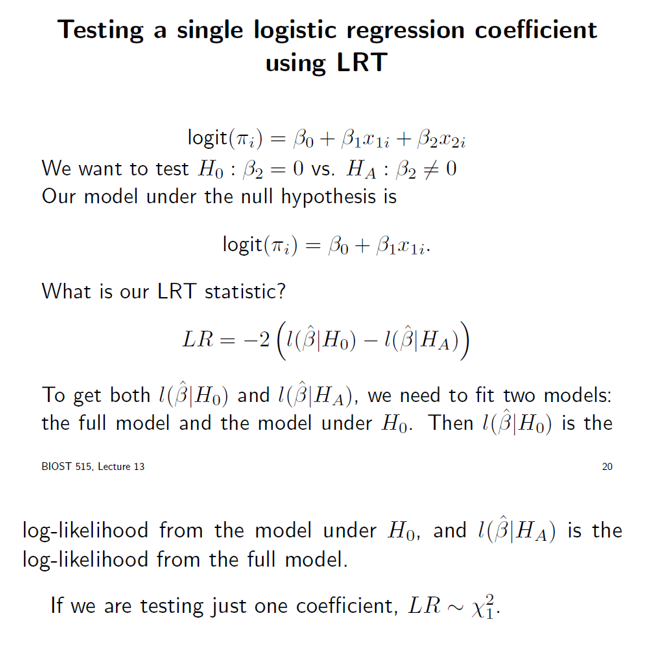

### 2.1.1 A One-line Predictor with 100% Accuracy? Features that shouldn't appear in prediction

#### Payment Data on Concluded Loans: Spurious Correlation

We can build a 100% accurate default predictor by testing whether the `Total Recieved Principle` is less than `Amound Funded`. The logic is simple: any concluded loan is defaulted on when and only when the principle is not fully paid. Both our training and test sets contain only concluded loans.

This is apparently too good to be true. In actual predictive settings, we won't have the luxury of owning such conclusive payment data. In real-world scenarios: we're either pricing a new loan, or monitoring an ongoing loan. In the first case, no payment data are available; in the second case, payment information in the training set captures spurious correlations that won't exist in the test set. Our training data is strictly conditioned on the fact that loans have already concluded; they don't say much about the feature dynamics given the loan is still ongoing. Just like a time series can be conditionally heteroscedastic but unconditionally homoscedastic, properties that exist under one condition will likely fail in general!

(Example on time series: let $\epsilon_i = f(x_i)\eta_i$, where $x_i$ and $\eta_i$ are independent, and both stationary and zero-mean. $Var(\epsilon_i|x_i) = f(x_i)^2Var(\eta_i)$ depends on $x_i$, but $Var(\epsilon_i) = Var(f(x_i))Var(\eta_i)$ which is constant.)

(We can also look at this from a modeling perspective. A 100% accurate predictor means that the model has captured the whole truth, and incorporating any other feature into the model would be overfitting. This would render the rest of the project meaningless. <span style=color:red> As such, we have to discard the any data related to loan payment.</span> )

_A Sidenote on Application Scenario_ 

Due to inherent deficiency in the dataset, we __don't__ recommend using this classifer to monitor any ongoing loans. A possible remedy would be expanding the dataset to include each feature's evolution through time, but doing so would make the dataframe 3D, and hence requires more advanced modeling techniques. 


#### Last Credit Pulled Date: Reverse Causality that won't Manifest Until Default

Below is a histogram of number of days that transpired between issuance and __LAST__ credit check (by Lending Club). Observe that at around day 1080, a large batch of loans go through their last credit check. This timing coincides with the actual lifespan of a majority of loans. Further notice the similarity in shape of both distributions prior to day 1080 -- almost as many loans terminate as have their last credit record pulled. If Lending Club performs regular credit check on on-going loans, this is the exact sort of behavior we'd see from the graph. 

Lending Club claims that they can make soft inquiries on applicant's credit scores (https://help.lendingclub.com/hc/en-us/articles/214869618-Will-checking-my-rate-affect-my-credit-score-). If they are not limited in the number of credit check they can perform, it makes perfect business sense to regularly soft-pull credit records for on-going loans. Therefore, the number of days that transpired between `Issued Date` and `Last Credit Pulled Date` can be intepreted as length of the period where the applicant's credit scoring is actively monitored. 

From the histogram we can see almost no defaulted loans have a monitoring period shorter than 36 months. A likely cause is that for defaulted borrowers, Lending Club would continue tracking their credit situation to assess the likelihood of recovery. In other words, it is because the loans have been defaulted on that their monitoring period is long, not the other way around.

Such reverse causality won't manifest itself for ongoing loans, because their credit monitoring period will almost certainly equal their current lifespan. Any information captured by `Last Credit Pulled Date` will likely be already incorporated in how long the loan has lasted. <span style=color:red> So even if we have time series data on each loan, `Last Credit Pulled Date` shouldn't be included as a predictive variable. </span>

#### Other Variables that Won't Be Present in Actual Prediction

- Loan Grades. In real-world setting, loan grades are assigned based on PV of expected loss, which is what we're supposed to model.
- The `Funded Ratio`, defined as `Amount Funded` over `Loan Amount` in reality is also determined after PD has been calculated. We do detect a statistically significant difference in `Funded Ratio` between default and non-defaulted loans, suggesting Lending Club did take default risk into acount when determining whether to fully grant the applied amount. <span style=color:red> Percentage funded by investor reflect market tolerance! Investors select loans explicitly! https://help.lendingclub.com/hc/en-us/articles/216109777-How-do-investors-select-which-loans-to-invest-in-</span>
- Settlement-related data. No settlement plan should be set-up before the loan is concluded. So we also remove the settlement related columns from the dataset.
- `Earliest Credit Line`. We added a column displaying length of credit history in months at the time of issuance. That full incorporates information in `Earliest Credit Line`.

- The extracted `Industry` data. Only less than 15% of borrowers had their industry information successfully extracted from `Employer Title`. The data quality is too poor.


In [38]:
test_pred["Issued Date"]

0      2011-12-01
1      2011-12-01
2      2011-12-01
3      2011-12-01
4      2011-12-01
          ...    
3972   2011-11-01
3973   2011-11-01
3974   2011-11-01
3975   2011-11-01
3976   2011-11-01
Name: Issued Date, Length: 3977, dtype: datetime64[ns]

In [6]:
# A 100% accurate classifier?
prediction = (test["Total Received Principle"] < test["Funded Amount"]).astype(int)
(prediction != test["Loan Status"]).sum()
# % of loans defaulted
training["Term"].value_counts().to_frame()/training.shape[0]

0

,Term
36 months,0.731453
60 months,0.268547


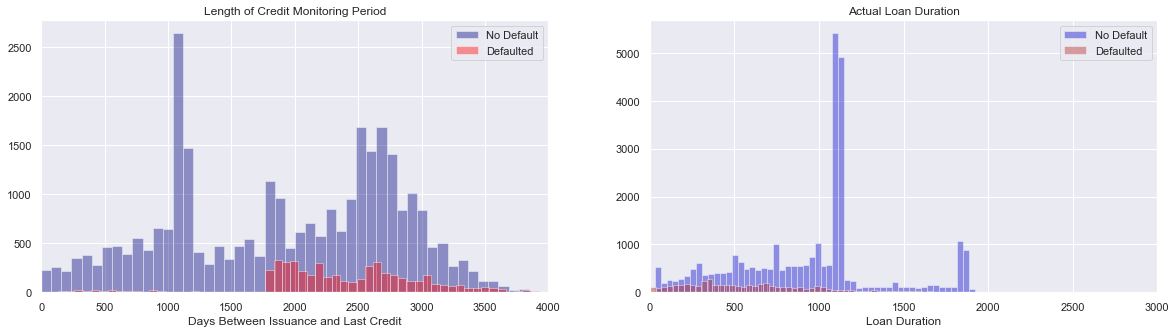

In [137]:
# Last Credit Pulled Date: Reverse causality
training["Days Between Issuance and Last Credit"] = training["Last Credit Pulled Date"] - training["Issued Date"]
training["Days Between Issuance and Last Credit"] = training["Days Between Issuance and Last Credit"].dt.days
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
sns.distplot(training.query("`Loan Status` == 0")["Days Between Issuance and Last Credit"], bins=60, color="navy", kde=False, label="No Default", ax=ax1)
sns.distplot(training.query("`Loan Status` == 1")["Days Between Issuance and Last Credit"], bins=60, color="red", kde=False, label="Defaulted", ax=ax1)
ax1.set_xlim(0,4000)
ax1.set_title("Length of Credit Monitoring Period")
ax1.legend()
# Juxtaposing against Actual Loan duration 
training["Loan Duration"] = (training["Last Payment Date"] - training["Issued Date"]).dt.days
sns.distplot(training.query("`Loan Status` == 0")["Loan Duration"],bins=60, color="mediumblue", kde=False, label="No Default", ax=ax2)
sns.distplot(training.query("`Loan Status` == 1")["Loan Duration"],bins=60, color="firebrick", kde=False, label="Defaulted", ax=ax2)
ax2.set_xlim(0,3000)
ax2.set_title("Actual Loan Duration")
ax2.legend()
training.drop(columns=["Loan Duration"], inplace=True)
training.drop(columns=["Days Between Issuance and Last Credit"], inplace=True)
plt.show();

Ttest_indResult(statistic=12.749793135280502, pvalue=4.178924050018035e-33)


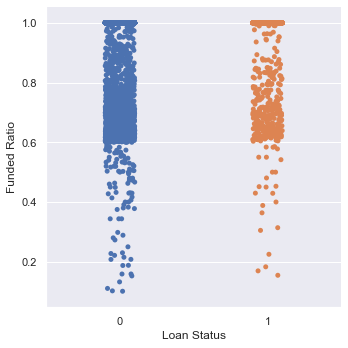

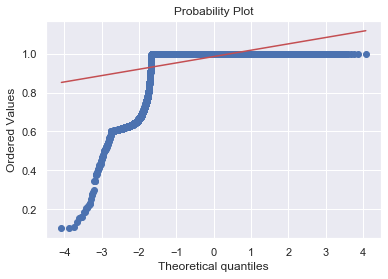

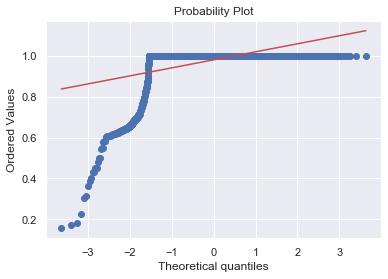

In [134]:
# Do defaulted loans have a lower funded ratio?
training["Funded Ratio"] = training["Funded Amount"]/training["Loan Amount"]
training["Fully Funded"] = (training["Funded Ratio"] == 1).astype(int)
sns.catplot(data=training, x="Loan Status", y="Funded Ratio", kind="strip")

# Check the funded ratio of two groups
training.groupby("Loan Status").apply(lambda x: x["Funded Ratio"].mean()).to_frame()

# An unpaired t-test
# Check varaince through Levene test. Two groups have different varaince. We do a Welch t-test.
stats.levene(training.query("`Loan Status` == 0")["Funded Ratio"], training.query("`Loan Status` == 1")["Funded Ratio"]) 

# Check normality. Clearly failed.
plt.figure()
stats.probplot(training.query("`Loan Status` == 0")["Funded Ratio"], dist="norm", plot = plt);
plt.figure()
stats.probplot(training.query("`Loan Status` == 1")["Funded Ratio"], plot = plt);


# Have to bootstrap the means.
def bootstrap_mean(series, num_of_times=300):
    n = series.size // 20
    means = []
    for i in range(num_of_times):
        sample = np.random.choice(series, size=n, replace=True)
        means.append(sample.mean())
    return np.array(means)

mean_funded_ratio_no_default = bootstrap_mean(training.query("`Loan Status` == 0")["Funded Ratio"])
mean_funded_ratio_default = bootstrap_mean(training.query("`Loan Status` == 1")["Funded Ratio"])

print(stats.ttest_ind(mean_funded_ratio_no_default, mean_funded_ratio_default))



#
# def welch_ttest(x, y): 
#     ## Welch-Satterthwaite Degrees of Freedom ##
#     dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
#     t, p = stats.ttest_ind(x, y, equal_var = False)
    
#     print("\n",
#           f"Welch's t-test= {t:.4f}", "\n",
#           f"p-value = {p:.4f}", "\n",
#           f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")


training.drop(columns=["Funded Ratio", "Fully Funded"], inplace=True)
plt.show();

In [138]:
features_not_in_prediction = ["Debt Settlement Flag", "Debt Settlement Flag Date", "Settlement Status", "Settlement Date", "Settlement Amount", 
                     "Settlement Term", "Settlement Percentage",
                     "Total Payment", "Total Payment Investor", "Total Received Principle", "Total Received Interest", 
                      "Total Received Late Fee", "Recoveries", "Collection Recovery Fee", "Last Payment Date", "Last Payment Amount",
                              "Last Credit Pulled Date",
                     "Funded Amount", "Funded Amount Investor", 
                              "Earliest Credit Line",
                      "Grade", "Sub Grade",
                     "Industry"]
training_pred = training.drop(columns=features_not_in_prediction)
test_pred = test.drop(columns=features_not_in_prediction)
training_pred.head()

,Loan Amount,Term,Interest Rate,Installment,Loan Status,Issued Date,Title,Description,Purpose,Employer Title,Employment Length,Home Ownership,Annual Income,Verification Status,Zip Code,State,Debt-to-income Ratio,Delinquencies in 2 years,Inquiries in 6 months,Months Since Last Delinquency,Months Since Last Public Record,Open Accounts,Derogatory Public Records,Revolving Balance,Revolving Balance Utilization,Number of Total Accounts,Public Bankcruptcy Records,Credit History Length in Months,Statewide Unemployment at Issuance,GDP Quarterly Growth at Issuance
0,35000,60 months,11.71,773.44,1,2011-11-01,Restaurant Inventory,Loan proceeds will be used to partially fund a...,small_business,US Department of Labor,10+ years,MORTGAGE,110000.0,Verified,945xx,CA,1.06,0,0,0,0,10,0,4142,0.064,27,0,490,11.3,4.7
1,9500,36 months,14.65,327.70,0,2011-11-01,familyneeds my help,i need this money to help my family in Thailan...,other,costco wholesales,10+ years,RENT,54000.0,Verified,334xx,FL,17.69,0,1,0,0,6,0,5460,0.853,11,0,126,9.3,4.7
2,3800,36 months,7.51,118.23,1,2011-11-01,Motorcycle Loan,NaN,car,Five Guys,< 1 year,MORTGAGE,47000.0,Source Verified,132xx,NY,22.52,0,3,0,0,10,0,8100,0.393,41,0,113,8.5,4.7
3,12400,60 months,22.06,342.90,1,2011-11-01,Debt Consolidation Loan,NaN,debt_consolidation,carmelo policaro construction,9 years,OWN,65004.0,Source Verified,077xx,NJ,6.26,0,3,78,0,11,0,8990,0.775,21,0,91,9.2,4.7
4,4000,60 months,17.27,100.00,1,2011-11-01,Medical,NaN,other,Tax Return Center,4 years,RENT,45000.0,Source Verified,331xx,FL,7.37,0,0,50,0,10,0,4786,0.825,13,0,105,9.3,4.7


In [12]:
features_not_significant = ["Issued Date"]

#### 2.1.2 Loan Condition:

We have to include `Loan Amount`. `Interest Rate`. __NO__

- `Term`?
- `Issued Date`? 
- `Installment`? __NO__
- Length of Description

__Term__

22.1% of the 5-year loans are defaulted, while within 3-year loans the proportion is 10.7%. A part of that may have been caused by difference in `Loan Size` and `Interest Rate`: from boxen plots (fancier boxplots that show more quantile) below, we can see that 5-year loans generally have a bigger loan size and are charged a higher interest rate. 

Yet `Loan Size` and `Interest Rate` don't fully capture `Term`'s impact on probability default. As the p-value from ANOVA test is almost 0,  we have to reject the null at 5% significance level.

We thus include `Term` as a input variable.

Text(0.5, 1.0, 'Number of Loans by State')

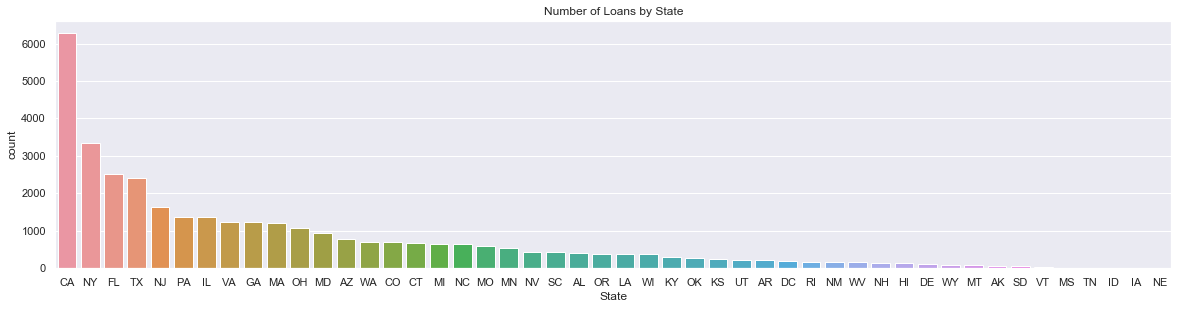

,Pct,Cumulative Pct
CA,0.179155,0.179155
NY,0.095639,0.274794
FL,0.071708,0.346502
TX,0.068713,0.415214
NJ,0.046636,0.461850
PA,0.039048,0.500898
IL,0.038706,0.539605
VA,0.035455,0.575059
GA,0.034998,0.610057
MA,0.034228,0.644285


In [23]:
# Quick look at distribution by state
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(2, 1, 1)
sns.countplot(data=training_pred, x="State", ax=ax, order=training_pred["State"].value_counts().index)
ax.set_title("Number of Loans by State")
plt.show();
# Percentage Accounted for
pct_loans_by_state = (training_pred["State"].value_counts().to_frame() / training_pred.shape[0])
pct_loans_by_state.columns = ["Pct"]
pct_loans_by_state["Cumulative Pct"] = pct_loans_by_state["Pct"].cumsum()
pct_loans_by_state.head(15)

Text(0.5, 1, 'Default Rate by Term \n 3-year: 10.7%, 5-year: 22.1%')

,Default Rate
Term,
36 months,0.107706
60 months,0.221880


Text(0.5, 1, 'Loan Amount by Term')

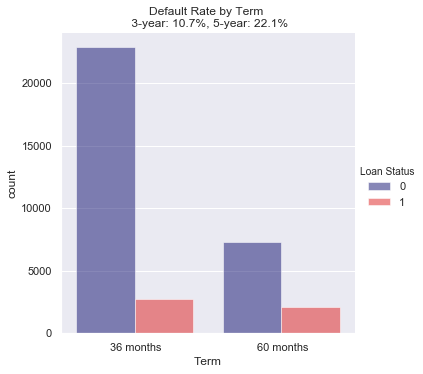

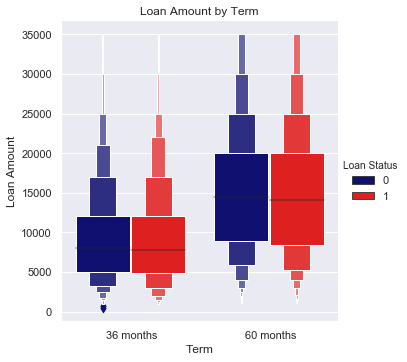

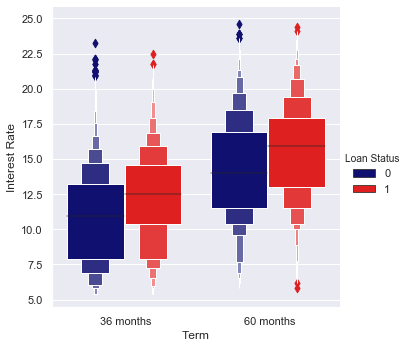

In [24]:
## Does Term matter?
# Default rate by loan term. Default rate for longer term loans is significantly higher.
sns.catplot(data=training_pred, x="Term", hue="Loan Status", kind="count", palette={1: "red", 0: "navy"}, order=training_pred["Term"].value_counts().index, alpha=0.5)
plt.title("Default Rate by Term \n 3-year: 10.7%, 5-year: 22.1%")

default_by_term = training_pred.groupby("Term").apply(default_rate).to_frame()
default_by_term.columns = ["Default Rate"]
default_by_term

# Can it be explained by Loan Size / Interest Rate?
# 60-month loans on average have larger size and higher interest rate.
np.random.seed(123)
index = np.random.choice(training_pred.shape[0], size=training_pred.shape[0]//30, replace=False)
g = sns.catplot(data=training_pred, x="Term", y="Loan Amount", hue="Loan Status", palette={1: "red", 0: "navy"}, kind="boxen", order=training_pred["Term"].value_counts().index)
g.ax.set_title("Loan Amount by Term")
g2 = sns.catplot(data=training_pred, x="Term", y="Interest Rate", hue="Loan Status", palette={1: "red", 0: "navy"}, kind="boxen", order=training_pred["Term"].value_counts().index)


In [33]:
type(summary1)

statsmodels.iolib.summary.Summary

In [34]:
summary1 = m1.fit().summary()
fit1 = m1.fit()
summary1.tables[0].data
fit1.llf
extract_log_lik_summary(summary1)

[['Dep. Variable:', 'Loan_Status', '  No. Observations:  ', ' 35059'],
 ['Model:', 'GLM', '  Df Residuals:      ', ' 35056'],
 ['Model Family:', 'Binomial', '  Df Model:          ', '     2'],
 ['Link Function:', 'logit', '  Scale:             ', '  1.0000'],
 ['Method:', 'IRLS', '  Log-Likelihood:    ', ' -13444.'],
 ['Date:', 'Fri, 06 Dec 2019', '  Deviance:          ', '  26888.'],
 ['Time:', '20:41:22', '  Pearson chi2:      ', '3.47e+04'],
 ['No. Iterations:', '5', '                     ', ' '],
 ['Covariance Type:', 'nonrobust', '                     ', ' ']]

-13444.032941912605

-13444

In [15]:
## Continued on Term.
# A self-defined ANOVA test.
def extract_log_lik_summary(summary):
    logLik = summary.tables[0].data[4][3]
    return int(logLik[:-1])

def extract_num_of_parameters(summary):
    return len(summary.tables[1].data) - 1

# m1 is supposed to be the sub model, and m2 the full model
def anova_logistics(m1, m2):
    summary1 = m1.fit().summary()
    summary2 = m2.fit().summary()
    nop1 = extract_num_of_parameters(summary1)
    nop2 = extract_num_of_parameters(summary2)
    twice_neg_logLik1 = -2 * extract_log_lik_summary(summary1)
    twice_neg_logLik2 = -2 * extract_log_lik_summary(summary2)
    test_statistic = twice_neg_logLik1 - twice_neg_logLik2
    # number of paramters being tested
    ddof = nop2 - nop1
    pvalue = 1 - stats.chi2.cdf(test_statistic, ddof)
    result = {
        "test-statistic" : test_statistic,
        "p-value": pvalue
    }
    print("Summary of ANOVA on logistics regression using likelihood ratio:")
    print(result)
#     return result

In [40]:
## Continued on Term.
# Let's do an anova test on two logistics regression: one including Loan Amount, Loan Status, the other one with the addition of Term
df = training_pred.copy(deep=True)
df.drop(columns="Issued Date", inplace=True)
df.columns = df.columns.str.replace(" ", "_")
# ANOVA for two models
endog = df["Loan_Status"]
exog1 = df.loc[:,["Loan_Amount"]]
exog1 = sm.add_constant(exog1)
exog2 = df.loc[:,["Loan_Amount", "Term"]]
exog2 = sm.add_constant(exog2)
exog2 = pd.get_dummies(exog2, prefix=["Term"]).drop(columns=["Term_ 60 months"])
m1 = sm.GLM(endog, exog1, family=sm.families.Binomial())
m2 = sm.GLM(endog, exog2, family=sm.families.Binomial())
# fit1 = sm.GLM(formula='Loan_Status ~ Loan_Amount + Interest_Rate', data=df, family=sm.families.Binomial())
anova_logistics(m1,m2)

Summary of ANOVA on logistics regression using likelihood ratio:
{'test-statistic': 636, 'p-value': 0.0}


C:\Users\nleea\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


#### Continued on 2.1.2: Loan Conditions

__Issued Date__

Do loans issued later have a higher default probability? The correlation is spurious as best. The plot below confirms this -- proportion of loans defaulted fluctuates over `Issued Date`, but the general trend is constant. The inital spike results from small sample in data, and isn't representative of the general truth.

(0, 0.3)

,Issued Date
2011-10-01,2117
2011-09-01,2067
2011-08-01,1934
2011-07-01,1872
2011-06-01,1834


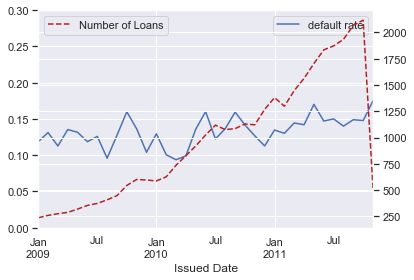

In [90]:
## Does Issued Date matter?
fig = plt.figure()
ax1 = fig.add_subplot(111)
default_by_issued_date = training_pred[training_pred["Issued Date"] > "2008-12-01"].groupby("Issued Date").apply(default_rate).to_frame()
default_by_issued_date.columns = ["default rate"]
default_by_issued_date.plot(ax=ax1, kind="line");
plt.ylim(0,0.3)

# Overlaying with the number of loans
ax2 = ax1.twinx()
num_of_loan_issued_date = training_pred[training_pred["Issued Date"] > "2008-12-01"].groupby("Issued Date").size().to_frame()
num_of_loan_issued_date.columns = ["Number of Loans"]
num_of_loan_issued_date.plot(ax=ax2, kind="line", style="--", color="firebrick");

training_pred["Issued Date"].value_counts().to_frame().head()


__Installment__

Although installment is by definition determined by loan size and interest rate, including installment on the basis of `Loan Amount`, `Interest Rate` and `Term` turns out to make statistical sense. We will thus keep the `Installment` variable, keeping in mind that any change in `Loan Amount` or `Interest Rate` needs to reflect on `Installment` as well.

Text(0.5, 1, 'Installment determined from loan size and interest')

Summary of ANOVA on logistics regression using likelihood ratio:
{'test-statistic': 58, 'p-value': 2.6201263381153694e-14}


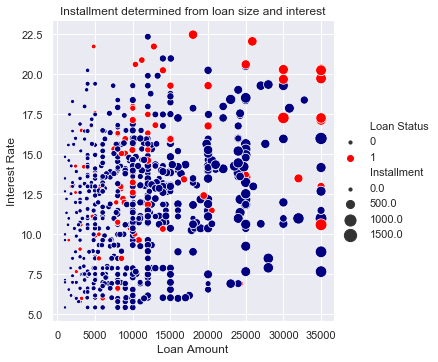

In [42]:
## Installment
np.random.seed(123)
num_samples = training_pred.shape[0]
index = np.random.choice(num_samples, num_samples//50)
sns.relplot(data=training_pred.iloc[index, :], x="Loan Amount", y="Interest Rate", hue="Loan Status", size="Installment",
            palette={0:"navy", 1:"red"}, sizes=(10,150))
plt.title("Installment determined from loan size and interest")

##
exog3 = exog2.copy(deep=True)
exog3["Installment"] = training_pred["Installment"]
m3 = sm.GLM(endog, exog3, family=sm.families.Binomial())
anova_logistics(m2, m3)

__Length of Description__

### 2.1.3 Borrower Financial Condition



In [139]:
training_pred.head()

,Loan Amount,Term,Interest Rate,Installment,Loan Status,Issued Date,Title,Description,Purpose,Employer Title,Employment Length,Home Ownership,Annual Income,Verification Status,Zip Code,State,Debt-to-income Ratio,Delinquencies in 2 years,Inquiries in 6 months,Months Since Last Delinquency,Months Since Last Public Record,Open Accounts,Derogatory Public Records,Revolving Balance,Revolving Balance Utilization,Number of Total Accounts,Public Bankcruptcy Records,Credit History Length in Months,Statewide Unemployment at Issuance,GDP Quarterly Growth at Issuance
0,35000,60 months,11.71,773.44,1,2011-11-01,Restaurant Inventory,Loan proceeds will be used to partially fund a...,small_business,US Department of Labor,10+ years,MORTGAGE,110000.0,Verified,945xx,CA,1.06,0,0,0,0,10,0,4142,0.064,27,0,490,11.3,4.7
1,9500,36 months,14.65,327.70,0,2011-11-01,familyneeds my help,i need this money to help my family in Thailan...,other,costco wholesales,10+ years,RENT,54000.0,Verified,334xx,FL,17.69,0,1,0,0,6,0,5460,0.853,11,0,126,9.3,4.7
2,3800,36 months,7.51,118.23,1,2011-11-01,Motorcycle Loan,NaN,car,Five Guys,< 1 year,MORTGAGE,47000.0,Source Verified,132xx,NY,22.52,0,3,0,0,10,0,8100,0.393,41,0,113,8.5,4.7
3,12400,60 months,22.06,342.90,1,2011-11-01,Debt Consolidation Loan,NaN,debt_consolidation,carmelo policaro construction,9 years,OWN,65004.0,Source Verified,077xx,NJ,6.26,0,3,78,0,11,0,8990,0.775,21,0,91,9.2,4.7
4,4000,60 months,17.27,100.00,1,2011-11-01,Medical,NaN,other,Tax Return Center,4 years,RENT,45000.0,Source Verified,331xx,FL,7.37,0,0,50,0,10,0,4786,0.825,13,0,105,9.3,4.7


In [120]:
g.ax

#### 2.1.2 Loan Condition

__Purpose__

A re-categorization of purpose: has_to, want_to or not_sure. <span style=color:red> The want_to group might have a stronger financial condition by applicant's self-selection.</span>

- Has_to: debt_consolidation, credit_card, medical
- Want_to: 
- Unknown: other, small_businesses

,Purpose
debt_consolidation,16260
credit_card,4242
other,3583
home_improvement,2734
major_purchase,2063
small_business,1630
car,1440
wedding,862
medical,631
moving,533


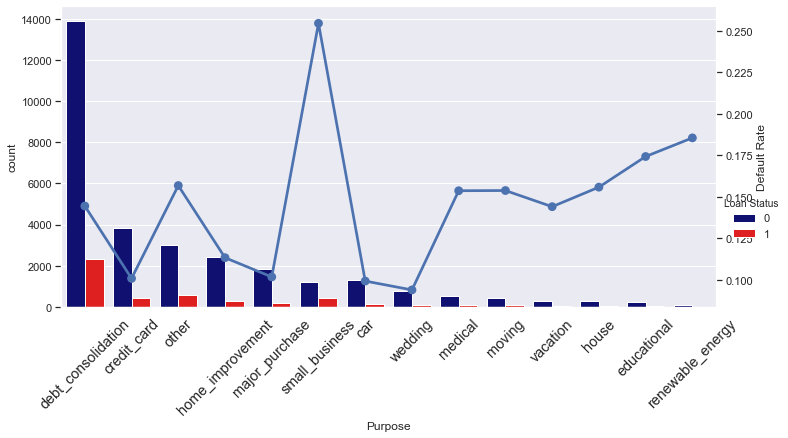

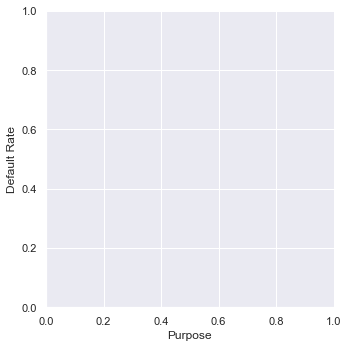

In [130]:
## Purpose matters?
training_pred["Purpose"].value_counts().to_frame()
# 
g = sns.catplot(data=training_pred, x="Purpose", kind="count", hue="Loan Status", palette={1: "red", 0: "navy"}, height=5, aspect=2,
               order=training_pred["Purpose"].value_counts().index)
g.set_xticklabels(rotation=45, fontsize='large')
## the twinx method is very useful
ax2 = g.ax.twinx()
default_by_purpose = training.groupby("Purpose").apply(default_rate).to_frame()
default_by_purpose.columns = ["Default Rate"]
default_by_purpose.reset_index(inplace=True)
sns.catplot(data=default_by_purpose, x="Purpose", y="Default Rate", kind="point", ax=ax2, order=training_pred["Purpose"].value_counts().index)
ax2.grid(False)


What we have to include:
- `Loan Amount`
- `Interest Rate`
- `Homeownership`
- `Annual Income` & what to do with `Verification Status`
- `Debt-to-income Ratio`
- `GDP Quarterly Growth at Issuance`, `Statewide Unemployment at Issuance`

What we need to decide on:

- Loan Parameter: `Installment`, `Term`, `Issued Date`
- `Title`, `Description`, `Purpose`
- Employment Condition: `Employer Title`, `Employment Length`
- Macroeconomic Conditions: `Zipcode`, `State`, `Statewide Unemployment at Issuance`, `GDP Quarterly Growth at Issuance`
- Credit - late payments and other credit burdens: `Delinquencies in 2 years`, `Months Since Last Delinquency`, `Months Since Last Public Record`, `Inquiries in 6 months`, `Open Accounts`, `Derogatory Public Records`, `Public Bankcruptcy Records`
- Credit - utilization: `Revolving Balance Utilization`, `Revolving Balance`